In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_csv('credit_score_cleaned_train.csv', low_memory=False)
raw.columns

Index(['id', 'customer_id', 'month', 'name', 'age', 'ssn', 'occupation',
       'annual_income', 'monthly_inhand_salary', 'credit_history_age',
       'total_emi_per_month', 'num_bank_accounts', 'num_credit_card',
       'interest_rate', 'num_of_loan', 'type_of_loan', 'delay_from_due_date',
       'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'credit_mix', 'outstanding_debt',
       'credit_utilization_ratio', 'payment_of_min_amount',
       'amount_invested_monthly', 'payment_behaviour', 'monthly_balance',
       'credit_score'],
      dtype='object')

In [3]:
raw = raw.dropna()
raw = raw.drop(['id', 'customer_id', 'name', 'ssn', 'type_of_loan'], axis='columns')
raw.dtypes

month                        object
age                           int64
occupation                   object
annual_income               float64
monthly_inhand_salary       float64
credit_history_age            int64
total_emi_per_month         float64
num_bank_accounts             int64
num_credit_card               int64
interest_rate                 int64
num_of_loan                   int64
delay_from_due_date           int64
num_of_delayed_payment        int64
changed_credit_limit        float64
num_credit_inquiries          int64
credit_mix                   object
outstanding_debt            float64
credit_utilization_ratio    float64
payment_of_min_amount        object
amount_invested_monthly     float64
payment_behaviour            object
monthly_balance             float64
credit_score                  int64
dtype: object

In [4]:
from itertools import chain

categorical = ['month', 'occupation', 'payment_behaviour']
ordinal = ['credit_mix', 'payment_of_min_amount']

for f in chain(categorical, ordinal):
    print(f'{f}: {*np.unique(raw[f]),}\n')

month: ('April', 'August', 'February', 'January', 'July', 'June', 'March', 'May')

occupation: ('Accountant', 'Architect', 'Developer', 'Doctor', 'Engineer', 'Entrepreneur', 'Journalist', 'Lawyer', 'Manager', 'Mechanic', 'Media_Manager', 'Musician', 'Scientist', 'Teacher', 'Writer')

payment_behaviour: ('High_spent_Large_value_payments', 'High_spent_Medium_value_payments', 'High_spent_Small_value_payments', 'Low_spent_Large_value_payments', 'Low_spent_Medium_value_payments', 'Low_spent_Small_value_payments')

credit_mix: ('Bad', 'Good', 'Standard')

payment_of_min_amount: ('No', 'Yes')



In [5]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

# Ignore categorical features
clean = raw.drop(categorical, axis='columns')

ordinal_encode = OrdinalEncoder(
    categories=[
        ['Bad', 'Standard', 'Good'],    # credit_mix
        ['No', 'Yes'],                  # payment_of_min_amount
    ]
)
clean[ordinal] = ordinal_encode.fit_transform(raw[ordinal])

In [6]:
from sklearn.model_selection import train_test_split

def normalize(df : pd.DataFrame):
    scaler = MinMaxScaler()
    features = df[df.columns.drop(['credit_score', 'monthly_inhand_salary'])]
    target = df['credit_score']

    X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2)

    # Normalize based only on the training data
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print(f'{X_train.shape}  {X_test.shape}')
    return X_train, X_test, Y_train, Y_test 

X_train, X_test, Y_train, Y_test = normalize(clean)

(77356, 18)  (19340, 18)


In [7]:
from sklearn.neighbors import KNeighborsClassifier

k_values = range(1, 11)
accuracy = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    accuracy.append(knn.score(X_test, Y_test))

k = np.argmax(accuracy)+1
print(f'Optimal KNN: k={k} with {100*(accuracy[k-1]):.2f}% Test Accuracy')

Optimal KNN: k=3 with 77.15% Test Accuracy


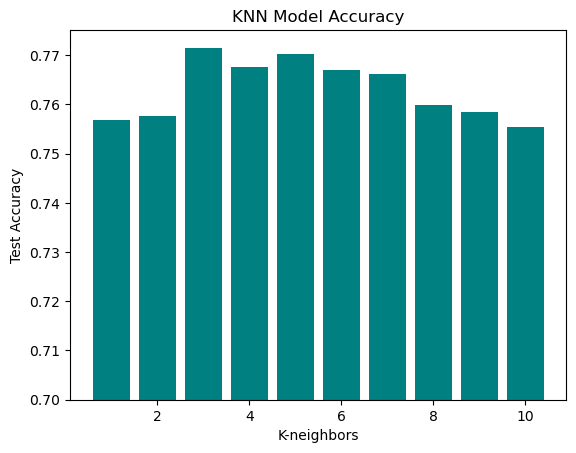

In [8]:
bottom = 0.70

plt.bar(k_values, np.array(accuracy)-bottom, bottom=bottom, color='teal')
plt.title('KNN Model Accuracy')
plt.xlabel('K-neighbors')
plt.ylabel('Test Accuracy')
plt.show()

In [9]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      5573
           1       0.80      0.78      0.79     10260
           2       0.72      0.72      0.72      3507

    accuracy                           0.77     19340
   macro avg       0.76      0.76      0.76     19340
weighted avg       0.77      0.77      0.77     19340



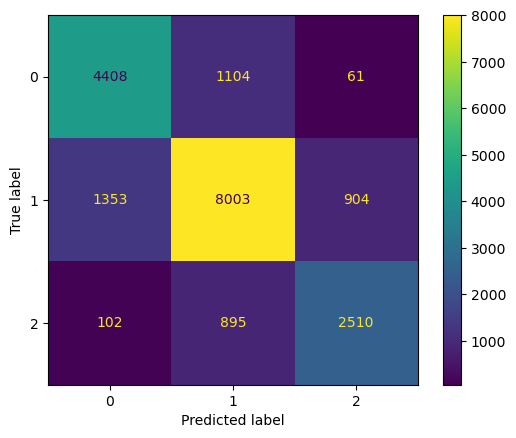

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred)
print(classification_report(Y_test,Y_pred))

In [11]:
from sklearn.cluster import KMeans

scaler = MinMaxScaler()
features = scaler.fit_transform(clean[clean.columns.drop(['credit_score', 'monthly_inhand_salary'])])
target = clean['credit_score']

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(features)

c, n = np.unique(clusters, return_counts=True)
for i in c:
    print(f'Cluster: {i}\tMembers: {n[i]}')

print()
c, n = np.unique(target, return_counts=True)
for i in c:
    print(f'Class:   {i}\tMembers: {n[i]}')

Cluster: 0	Members: 25641
Cluster: 1	Members: 40568
Cluster: 2	Members: 30487

Class:   0	Members: 27485
Class:   1	Members: 51503
Class:   2	Members: 17708


In [12]:
# Create a cross-tabulation
df_cluster=pd.DataFrame({'Actual': target, 'Cluster': clusters})
cross_tab = pd.crosstab(df_cluster['Actual'], df_cluster['Cluster'])

print(cross_tab)

Cluster      0      1      2
Actual                      
0        15966   5439   6080
1         9360  19509  22634
2          315  15620   1773


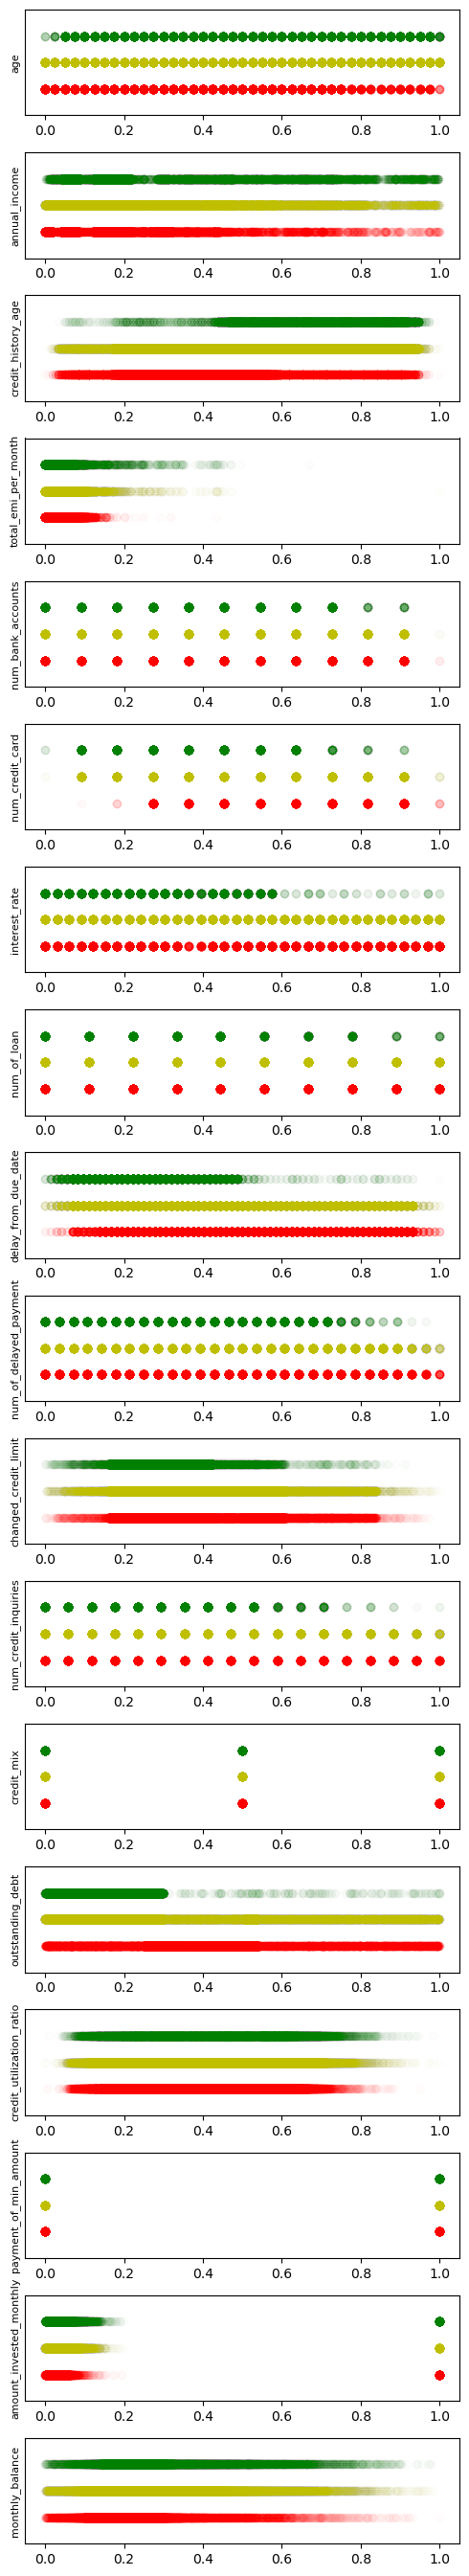

In [13]:
f_names = clean.columns.drop(['credit_score', 'monthly_inhand_salary'])

def plot_line(ax : plt.Axes, seq, name):

    for i, c in zip(range(3), ['r', 'y', 'g']):
        data = seq[target == i]
        ax.scatter(data, np.zeros_like(data)+i, color=c, alpha=0.01, marker='o')

    ax.set_ylabel(name, fontsize=8)
    ax.set_yticks([])
    ax.set_ybound(-1, 3)

n, m = features.shape
fig, axes = plt.subplots(m, 1, figsize=(5, 27))

for i in range(m):
    plot_line(axes[i], features[:,i], f_names[i])

fig.tight_layout()
plt.show()